## Extend the timeseries to 5000 years everywhere

options:
- very roughly: just use the last value from existing timeseries 
- slightly better: use the 20 last years and add them until the end of the timeseries
- do a fit to interpolate until 5000 years -> ***it is not so straightforward ...*** 

In [1]:
#DATE = 'apr04'
DATE = 'Jun29' #'MAY16' #'apr04'
# download it here https://cluster.klima.uni-bremen.de/~lschuster/glacierMIP3_analysis/glacierMIP3_mar14_models_all_rgi_regions_sum_scaled.nc
# and change the path to your local path
path_merged_runs_scaled = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from help_func import pal_models, model_order, d_reg_num_name

In [3]:
# pip install pymannkendall

In [4]:
import pymannkendall as mk

# these regions should run until 5000 years:
rgi_regs_5000 = ['01', '03', '04', '05', '06','07', '09', '17','19']        
# expand the rgi regions that only run until 2000 by using the last simulated year
n_increasing = 0
n_decreasing = 0
n_no_trend = 0
fill_option = 'repeat_last_20yrs'

ds_reg_models = xr.open_dataset(path_merged_runs_scaled)
ds_reg_models_extend = ds_reg_models.copy()
for gcm in np.arange(0,len(ds_reg_models_extend.gcm.values),1):
    for period_scenario in np.arange(0, len(ds_reg_models_extend.period_scenario),1):
        for m in np.arange(0, len(ds_reg_models_extend.model_author),1):
        
            ds = ds_reg_models_extend.isel(model_author=m).isel(gcm=gcm).isel(period_scenario=period_scenario)
            #print(ds)
            for rgi_reg_id,rgi_reg in enumerate(ds.rgi_reg.values): 
                if np.all(np.isnan(ds.sel(rgi_reg =rgi_reg).volume_m3.values)) and np.all(np.isnan(ds.sel(rgi_reg =rgi_reg).area_m2.values)):
                    # ok we do not have any regional data for that region, model_author, gcm, period_scenarios ... just keep the values np.NaN...
                    pass
                #elif rgi_reg in rgi_regs_5000:
                #    assert not np.any(np.isnan(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).volume_m3.values))
                else:
                    # check that all are not nan-values! -> then do not need to extend
                    if not np.any(np.isnan(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).volume_m3.values)):
                        pass
                    else:
                        #try:
                        # check that it is really always np.NaN values after simulation year 2000 for that region
                        assert np.all(np.isnan(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).volume_m3.values))
                        # Huss has area 0 for some regions 
                        assert np.all(np.isnan(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).area_m2.values)) or np.all(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).area_m2.values==0)

                        # fill them up with the last simulation year values 
                        # we fill that up that later 
                        #for y in np.arange(2001,5001):
                        if fill_option == 'last_value':
                            ds['volume_m3'].data[..., rgi_reg_id, 2001:] = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=2000).volume_m3.values
                            ds['area_m2'].data[..., rgi_reg_id, 2001:] = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=2000).area_m2.values
                        elif fill_option == 'repeat_last_20yrs':  # 20-yr period is repeated 150 times to fill up the additional 3000yrs
                            ds['volume_m3'].data[..., rgi_reg_id, 2001:] = np.tile(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1981,2000)).volume_m3.values, 150)
                            ds['area_m2'].data[..., rgi_reg_id, 2001:] = np.tile(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1981,2000)).area_m2.values, 150)
                        #print(gcm, period_scenario, ds_reg_models.isel(model_author=m).model_author.values, rgi_reg)

                        #except:
                        #    # ok some models did run over all regions for 5000 years
                        #    print('runs for 5000 years: ' , ds_reg_models.isel(model_author=m).model_author.values, rgi_reg)
                        #    pass
                        
                        dend = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1900,2000)).volume_m3
                        mk_output = mk.original_test(dend, alpha=0.01)
                        if mk_output.trend =='no trend':
                            n_no_trend +=1
                        elif mk_output.trend =='decreasing':
                            n_decreasing +=1
                        elif mk_output.trend =='increasing':
                            n_increasing +=1
                        #    print(mk_output, gcm, period_scenario, ds_reg_models.isel(model_author=m).model_author.values, rgi_reg)

            assert np.shape(ds_reg_models_extend['volume_m3'][m,gcm,:,:,period_scenario])== (19,5001)
            # add it to the big file 
            ds_reg_models_extend['volume_m3'].data[m,gcm,:,:,period_scenario] = ds['volume_m3'].values
            ds_reg_models_extend['area_m2'].data[m,gcm,:,:,period_scenario] = ds['area_m2'].values
            
ds_reg_models_extend.coords['extend_option'] = fill_option
#ds_reg_models_extend.to_netcdf(f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc')

In [7]:
n_no_trend, n_decreasing, n_increasing

(2219, 473, 378)

In [5]:
# OGGM_v16 gave global estimates -> after extending the timeseries, there should be no NaN values left 
assert not np.any(np.isnan(ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').values))

if fill_option == 'repeat_last_20yrs': 
    # check if values are all equal to the last 20 yr timeseries for a RGI region where there are no 
    for j in np.arange(0,3000,20):
        np.testing.assert_allclose(ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='02').sel(simulation_year = slice(1981,2000)).isel(gcm=0).isel(period_scenario=0),
                                   ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='02').sel(simulation_year = slice(2001+j,2020+j)).isel(gcm=0).isel(period_scenario=0))

    for j in np.arange(0,3000,20):
        np.testing.assert_allclose(ds_reg_models_extend.volume_m3.sel(model_author='Rounce').sel(rgi_reg='02').sel(simulation_year = slice(1981,2000)).isel(gcm=0).isel(period_scenario=0),
                                   ds_reg_models_extend.volume_m3.sel(model_author='Rounce').sel(rgi_reg='02').sel(simulation_year = slice(2001+j,2020+j)).isel(gcm=0).isel(period_scenario=0))

### Work in process: Do we need to do a fit???

/tmp/ipykernel_671031/2453980801.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(x))


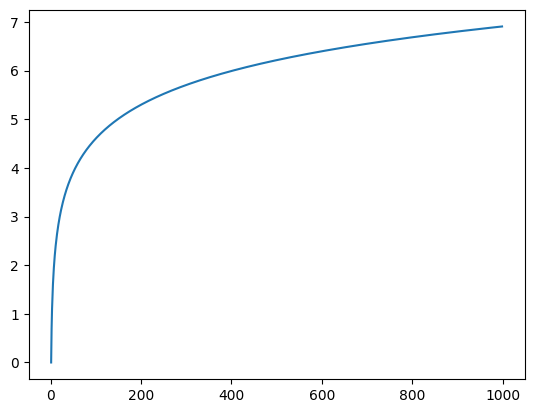

In [6]:
x=np.arange(0,1000,1)
plt.plot(np.log(x))

In [7]:
n_total = n_increasing+ n_increasing+n_no_trend
n_increasing/n_total

0.12705882352941175

In [8]:
n_decreasing/n_total

0.15899159663865547

In [9]:
dend = ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='13').sel(simulation_year = slice(1900,2000)).isel(gcm=0).isel(period_scenario=0)
dall = ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='13').sel(simulation_year = slice(0,2000)).isel(gcm=0).isel(period_scenario=0)
mk_output = mk.original_test(dend, alpha=0.01)
mk_output

Mann_Kendall_Test(trend='increasing', h=True, p=2.08909639254351e-06, z=4.7446088308081515, Tau=0.3203960396039604, s=1618.0, var_s=116150.0, slope=300303703.2010944, intercept=4719902094583.945)

In [98]:
import scipy

In [10]:
import pymannkendall as mk

def func(x, a, b,c,d,e): # x-shifted log
    return (a*np.exp(-b*x**d)+c)/e

from scipy.optimize import curve_fit

# these regions should run until 5000 years:
rgi_regs_5000 = ['01', '03', '04', '05', '06','07', '09', '17','19']        
# expand the rgi regions that only run until 2000 by using the last simulated year
n_increasing = 0
n_decreasing = 0
n_no_trend = 0
fill_option = 'fit'

ds_reg_models = xr.open_dataset(path_merged_runs_scaled)
ds_reg_models_extend = ds_reg_models.copy()
for gcm in np.arange(0,len(ds_reg_models_extend.gcm.values),1):
    for period_scenario in np.arange(0, len(ds_reg_models_extend.period_scenario),1):
        for m in np.arange(0, len(ds_reg_models_extend.model_author),1):
        
            ds = ds_reg_models_extend.isel(model_author=m).isel(gcm=gcm).isel(period_scenario=period_scenario)
            #print(ds)
            for rgi_reg_id,rgi_reg in enumerate(ds.rgi_reg.values): 
                if np.all(np.isnan(ds.sel(rgi_reg =rgi_reg).volume_m3.values)) and np.all(np.isnan(ds.sel(rgi_reg =rgi_reg).area_m2.values)):
                    # ok we do not have any regional data for that region, model_author, gcm, period_scenarios ... just keep the values np.NaN...
                    pass
                #elif rgi_reg in rgi_regs_5000:
                #    assert not np.any(np.isnan(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).volume_m3.values))
                else:
                    # check that all are not nan-values! -> then do not need to extend
                    if not np.any(np.isnan(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).volume_m3.values)):
                        pass
                    else:
                        #try:
                        # check that it is really always np.NaN values after simulation year 2000 for that region
                        assert np.all(np.isnan(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).volume_m3.values))
                        # Huss has area 0 for some regions 
                        assert np.all(np.isnan(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).area_m2.values)) or np.all(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(2001,5001)).area_m2.values==0)

                        # fill them up with the last simulation year values 
                        # we fill that up that later 
                        #for y in np.arange(2001,5001):
                        if fill_option == 'last_value':
                            ds['volume_m3'].data[..., rgi_reg_id, 2001:] = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=2000).volume_m3.values
                            ds['area_m2'].data[..., rgi_reg_id, 2001:] = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=2000).area_m2.values
                        elif fill_option == 'repeat_last_20yrs':  # 20-yr period is repeated 150 times to fill up the additional 3000yrs
                            ds['volume_m3'].data[..., rgi_reg_id, 2001:] = np.tile(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1981,2000)).volume_m3.values, 150)
                            ds['area_m2'].data[..., rgi_reg_id, 2001:] = np.tile(ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1981,2000)).area_m2.values, 150)
                        elif fill_option =='fit':
                            # let's only take the years 1000 to 2000
                            skip_yrs = 1000
                            dall = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(skip_yrs,2000))
                            #dall = ds_reg_models_extend.sel(model_author='OGGM_v16').sel(rgi_reg='13').sel(simulation_year = slice(0,2000)).isel(gcm=0).isel(period_scenario=0)

                            ### volume
                            p0 = [-dall.volume_m3.max(), 1, dall.volume_m3.max(),1,1]
                            fittedParameters, pcov = curve_fit(func, dall.simulation_year.values, dall.volume_m3.values, p0 = p0)
                            t = np.arange(skip_yrs,5001,1)
                            d_fit_volume_m3 = func(t, *fittedParameters) 
                            np.testing.assert_allclose(dall.volume_m3.values[:2000-skip_yrs], 
                                                       d_fit_volume_m3[0:2000-skip_yrs], rtol=0.1)
                            # area
                            p0 = [-dall.area_m2.max(), 1, dall.area_m2.max(),1,1]
                            fittedParameters, pcov = curve_fit(func, dall.simulation_year.values, dall.area_m2.values, p0 = p0)
                            t = np.arange(skip_yrs,5001,1)
                            d_fit_area_m2 = func(t, *fittedParameters) 
                            np.testing.assert_allclose(dall.area_m2.values[:2000-skip_yrs], 
                                                       d_fit_area_m2[:2000-skip_yrs], rtol=0.1)
                            
                            ds['volume_m3'].data[..., rgi_reg_id, 2001:] = d_fit_volume_m3[2000-skip_yrs+1:]
                            ds['area_m2'].data[..., rgi_reg_id, 2001:] = d_fit_area_m2[2000-skip_yrs+1:]
                        #print(gcm, period_scenario, ds_reg_models.isel(model_author=m).model_author.values, rgi_reg)

                        #except:
                        #    # ok some models did run over all regions for 5000 years
                        #    print('runs for 5000 years: ' , ds_reg_models.isel(model_author=m).model_author.values, rgi_reg)
                        #    pass
                        
                        dend = ds.sel(rgi_reg =rgi_reg).sel(simulation_year=slice(1900,2000)).volume_m3
                        mk_output = mk.original_test(dend, alpha=0.01)
                        if mk_output.trend =='no trend':
                            n_no_trend +=1
                        elif mk_output.trend =='decreasing':
                            n_decreasing +=1
                        elif mk_output.trend =='increasing':
                            n_increasing +=1
                        #    print(mk_output, gcm, period_scenario, ds_reg_models.isel(model_author=m).model_author.values, rgi_reg)

            assert np.shape(ds_reg_models_extend['volume_m3'][m,gcm,:,:,period_scenario])== (19,5001)
            # add it to the big file 
            ds_reg_models_extend['volume_m3'].data[m,gcm,:,:,period_scenario] = ds['volume_m3'].values
            ds_reg_models_extend['area_m2'].data[m,gcm,:,:,period_scenario] = ds['area_m2'].values
            
ds_reg_models_extend.coords['extend_option'] = fill_option

/home/users/lschuster/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/users/lschuster/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/users/lschuster/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/users/lschuster/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/users/lschuster/.local/lib/python3.10/site-packages/scipy/opti

AssertionError: 
Not equal to tolerance rtol=0.1, atol=0

Mismatched elements: 1 / 1000 (0.1%)
Max absolute difference: 6.85826814e+10
Max relative difference: 0.10396591
 x: array([6.497457e+11, 6.385385e+11, 6.305914e+11, 6.462005e+11,
       6.308221e+11, 6.440074e+11, 6.495733e+11, 6.528703e+11,
       6.437103e+11, 6.330936e+11, 6.501505e+11, 6.222874e+11,...
 y: array([6.596651e+11, 6.596651e+11, 6.596651e+11, 6.596651e+11,
       6.596651e+11, 6.596651e+11, 6.596651e+11, 6.596651e+11,
       6.596651e+11, 6.596651e+11, 6.596651e+11, 6.596651e+11,...

**below you can see one of the issues**

/tmp/ipykernel_3102955/2645228258.py:4: RuntimeWarning: overflow encountered in power
  return (a*np.exp(-b*x**d)+c)/e
/tmp/ipykernel_3102955/2645228258.py:4: RuntimeWarning: overflow encountered in exp
  return (a*np.exp(-b*x**d)+c)/e
/home/users/lschuster/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


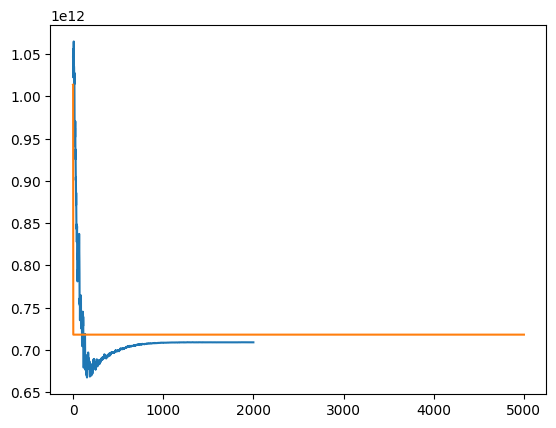

In [313]:
p0 = [-dall.volume_m3.max(), 1, dall.volume_m3.max(),1,1]
fittedParameters, pcov = curve_fit(func, dall.simulation_year.values, dall.volume_m3.values, p0 = p0)
t = np.arange(0,5001,1)
d_fit_volume_m3 = func(t, *fittedParameters) 

plt.plot(dall.volume_m3)

plt.plot(t,d_fit_volume_m3)

[-2.25290996e+12  1.32947258e-02  6.59375456e+12  7.45563511e-01
  1.38590735e+00]


/home/users/lschuster/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


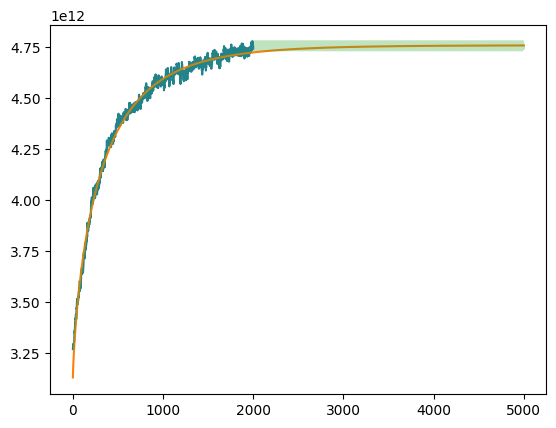

In [294]:


print(fittedParameters)
#absError = modelPredictions - yData

#SE = numpy.square(absError) # squared errors
#MSE = numpy.mean(SE) # mean squared errors
#RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
#Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))

t = np.arange(0,5001,1)
modelPredictions = func(t, *fittedParameters) 
plt.plot(dall.simulation_year, )
plt.plot(t,modelPredictions)

plt.plot(t, ds_reg_models_extend.volume_m3.sel(model_author='OGGM_v16').sel(rgi_reg='13').isel(gcm=0).isel(period_scenario=0), alpha = 0.3)

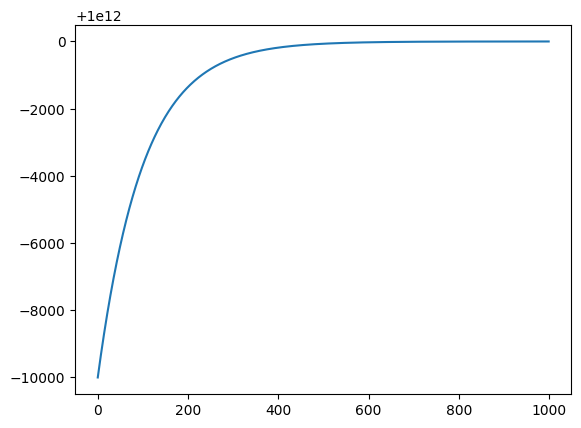

In [256]:
plt.plot(a*np.exp(-b*np.arange(0,1000,1))+c)

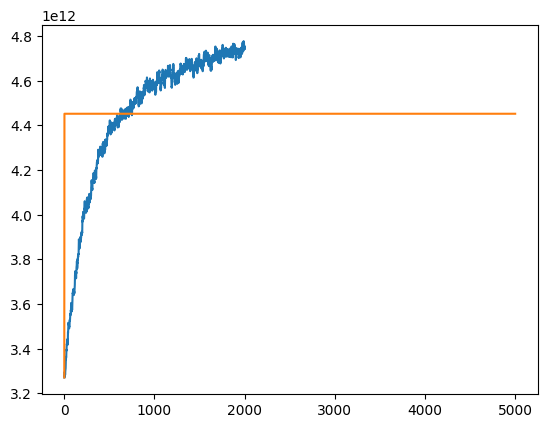

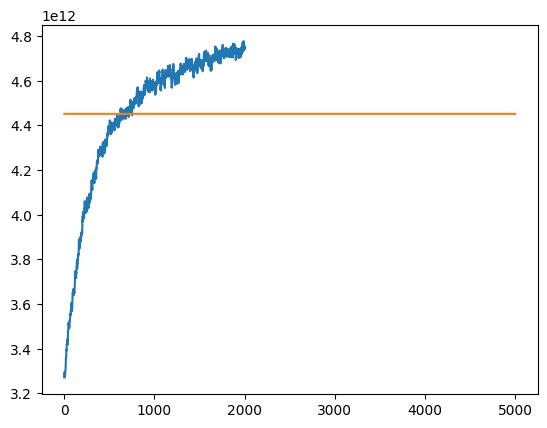